In [10]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

import torch
from torch import  nn
from torchvision import transforms ,datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.Mnist_selection import train_test_split

import os 

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
TrainSet=datasets.MNIST(root="/home/yash/CNN_Data",train=True,download=True,transform=transforms.ToTensor())
TestSet=datasets.MNIST(root="/home/yash/CNN_Data",train=False,download=False,transform=transforms.ToTensor())

In [14]:
DataSet=DataLoader(TrainSet,len(TrainSet))
for batch in DataSet:
    x,y=batch

In [25]:
DataSetTest=DataLoader(TestSet,len(TestSet))
for batch in DataSetTest:
    Xtesting, Ytesting=batch

Xtesting,Ytesting=Xtesting.to(device),Ytesting.to(device)

In [16]:
y[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

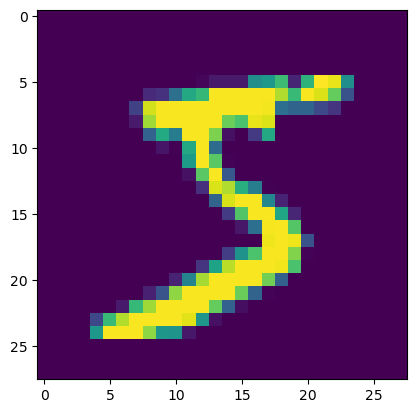

In [17]:
x=x.reshape(60000,28,28,1)

plt.imshow(x[0])

In [18]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.flaten=nn.Flatten()
        self.layer1 = nn.Linear(in_features=784,out_features=(784*2))
        self.layer2 = nn.Linear(in_features=(784*2),out_features=784)
        self.layer3 = nn.Linear(in_features=784,out_features=128)
        self.layer4 = nn.Linear(in_features=128,out_features=64)
        self.layer5 = nn.Linear(in_features=64,out_features=10)
        self.Relu=nn.ReLU()
        self.Sigmoid=nn.Sigmoid()

    def forward(self,DataSet):
        L0=(self.flaten(DataSet))
        L1=self.Relu(self.layer1(L0))
        L2=self.Relu(self.layer2(L1))
        L3=self.Relu(self.layer3(L2))
        L4=self.Relu(self.layer4(L3))
        L5=self.Sigmoid(self.layer5(L4))
        return(L5)


In [19]:
lr=1e-2

CIF=CIFAR10Model().to(device)
loss_fn =nn.CrossEntropyLoss()
opt=Adam(CIF.parameters(),lr)
scheduler = lr_scheduler.LinearLR(opt, start_factor=1.0, end_factor=0.001, total_iters=90)
scheduler_cos = lr_scheduler.CosineAnnealingLR(opt,T_max=20,eta_min=0.0001)

for batch in DataSet:
    batch
    Xtrain,Ytrain=batch

Xtrain,Ytrain=Xtrain.to(device),Ytrain.to(device)

In [20]:
epochs=100
epochs_count=[]
train_loss=[]
test_loss=[]

for epoch in range(epochs):

    for batch in DataSet:

        X_value,Y_value=batch

        Xtrain,Xtest,Ytrain,Ytest=train_test_split(X_value,Y_value,test_size=0.2)

        Xtrain,Ytrain=Xtrain.to(device),Ytrain.to(device)
        Xtest,Ytest=Xtest.to(device),Ytest.to(device)

        CIF.train()

        y_pred=CIF(Xtrain)
        
        loss=loss_fn(y_pred,Ytrain)


        opt.zero_grad()

        loss.backward()

        opt.step()

        CIF.eval()

        with torch.inference_mode():

            test_pred=CIF(Xtest)
            Tloss= loss_fn(test_pred,Ytest)
    before_lr = opt.param_groups[0]["lr"]
    scheduler_cos.step()
    after_lr = opt.param_groups[0]["lr"]
    print("Epoch %d: Adam lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

    print(f"epoch:{epoch} |  train loss is :- {loss.item()}")
    print(f"epoch:{epoch} |  test  loss is :- {Tloss.item()}")

    epochs_count.append((epoch))
    train_loss.append(loss.item())
    test_loss.append(Tloss.item())


Epoch 0: Adam lr 0.0100 -> 0.0099
epoch:0 |  train loss is :- 2.3028974533081055
epoch:0 |  test  loss is :- 2.2749810218811035
Epoch 1: Adam lr 0.0099 -> 0.0098
epoch:1 |  train loss is :- 2.2760496139526367
epoch:1 |  test  loss is :- 2.222486734390259
Epoch 2: Adam lr 0.0098 -> 0.0095
epoch:2 |  train loss is :- 2.223203659057617
epoch:2 |  test  loss is :- 2.3636834621429443
Epoch 3: Adam lr 0.0095 -> 0.0091
epoch:3 |  train loss is :- 2.365309000015259
epoch:3 |  test  loss is :- 2.236825466156006
Epoch 4: Adam lr 0.0091 -> 0.0086
epoch:4 |  train loss is :- 2.2320046424865723
epoch:4 |  test  loss is :- 2.062758684158325
Epoch 5: Adam lr 0.0086 -> 0.0080
epoch:5 |  train loss is :- 2.0590767860412598
epoch:5 |  test  loss is :- 2.06333589553833
Epoch 6: Adam lr 0.0080 -> 0.0073
epoch:6 |  train loss is :- 2.0614736080169678
epoch:6 |  test  loss is :- 1.9839314222335815
Epoch 7: Adam lr 0.0073 -> 0.0066
epoch:7 |  train loss is :- 1.9862457513809204
epoch:7 |  test  loss is :- 1.

The accuracy of the Mnist on the unknown data is:- 90.25999999999999%


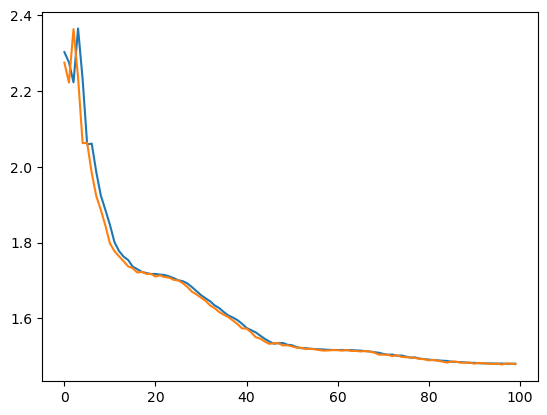

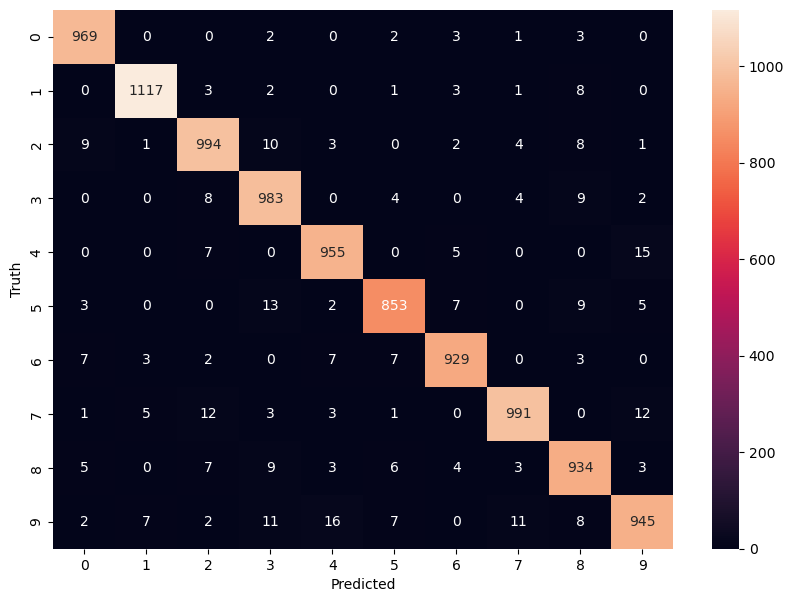

In [37]:
plt.plot(epochs_count,train_loss)
plt.plot(epochs_count,test_loss)

y_predicted =CIF(Xtesting)
y_predicted=y_predicted.cpu()
y_predicted=y_predicted.detach()

ytest=(Ytesting.cpu()).detach()

y_predicted_labels=[np.argmax(i) for i in y_predicted]

cm=confusion_matrix(ytest,y_predicted_labels)
cm

plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

sum=0

for i in Ytesting:
    if(y_predicted_labels[i]==Ytesting[i]):
        sum+=1

accuracy=(sum)/len(Ytesting)

print(f"The accuracy of the Mnist on the unknown data is:- {accuracy*100}%")